In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import EDMD, DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si
import time

## Importing the HF solution data

In [2]:
pist_pressure = np.load("../DATA/nonlin_Fsi_Results/nln_pist_pressure.npy")
nnt = pist_pressure.shape[0]
moving_mesh = np.load("../DATA/nonlin_Fsi_Results/nln_moving_mesh.npy")
delta_t = np.load("../DATA/nonlin_Fsi_Results/nln_delta_t.npy")
sol_accel = np.load("../DATA/nonlin_Fsi_Results/nln_sol_accel.npy")
velocity = np.load("../DATA/nonlin_Fsi_Results/nln_fl_velocity_end.npy")[0, :]

t = np.cumsum(delta_t)
nx = moving_mesh.shape[0]
nt = pist_pressure.shape[0]
L = 1
L0 = 1
mass = 1000
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid

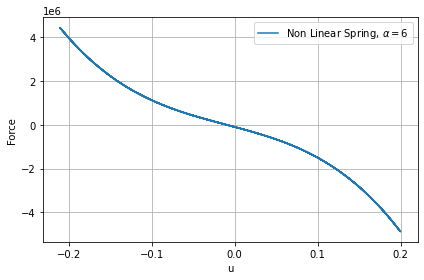

In [3]:
force = mass * sol_accel - pist_pressure
plt.plot(moving_mesh[-1, :] - L0, force, label=r"Non Linear Spring, $\alpha = 6$")
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();

**Interpolating on an equally sampled time grid**

In [4]:
# Choose number of equally spaced timesteps 
n_T = 3.5 # ~ Number of modes in data
n_snap = 280 # Number of snapshots in the train data
frac = 2 # ~ Number of time periods in the train data
ntt = int(n_snap /(frac/n_T)) # Number of snapshots in the test+train data
dt = (t[-1] - t[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_pist_pressure = si.griddata(t, pist_pressure.T, target_t, method='linear').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='linear').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='linear').T
target_velocity = si.griddata(t, velocity.T, target_t, method='linear').T

**Separating training and testing data**

In [5]:
Coeff = frac/n_T
train_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, :int(Coeff*ntt)]-L0
train_pres = target_pist_pressure.reshape((1, -1))[:, :int(Coeff*ntt)]
train_sol_accel = target_sol_accel.reshape((1, -1))[:, :int(Coeff*ntt)]
train_t = target_t[:int(Coeff*ntt)]

test_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, int(Coeff*ntt)::]-L0
test_pres = target_pist_pressure.reshape((1, -1))[:, int(Coeff*ntt)::]
test_sol_accel = target_sol_accel.reshape((1, -1))[:, int(Coeff*ntt)::]
test_t = target_t[int(Coeff*ntt)::]

X = train_disp[:1, :].reshape((1, -1))
Y = train_disp[:1, :].reshape((1, -1))
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : train_pres],  
               "Y" : [lambda x : train_sol_accel]}

## eDMD learning

In [6]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [ ]:
edmd.A

In [7]:
edmd.A

array([[-1.00939359e+04, -9.03701177e+03, -2.99976835e+05,
        -9.91063585e+01,  9.82767787e-04]])

The model did learn the correct spring parameters, (see [the eDMD Spring notebook](./eDMD_Spring.ipynb) )

## The prediction phase

Now that these parameters are known we can solve the following ODE for $\pmb{u(t)}$ and $\pmb{v(t)}$

$$(ODE1) : \pmb{\dot{y}} = 
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix} = f(\pmb{y}, t)$$
$d(t) = d_1 + d_2 * p(t)$

In [8]:
t0 = time.time()

# The interpolated function that returns the pressure value given a specific instant
from scipy import interpolate
p_ = interpolate.interp1d(target_t, target_pist_pressure, fill_value="extrapolate")
p = lambda t : float(p_(t))

# The spring paramteres learnt by eDMD
a = edmd.A[0, 0]
b = edmd.A[0, 1]
c = edmd.A[0, 2]
d1 = edmd.A[0, 3] 
d2 = edmd.A[0, 4]
d = lambda t : d1 + d2 * p(t)
v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

# The time interval on which to solve the ODE is the original data time interval
input_t = target_t.copy()

from scipy.integrate import solve_ivp
def f(t, y): return np.array([y[1], v_dot(y[0], t)])
sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)

t1 = time.time()

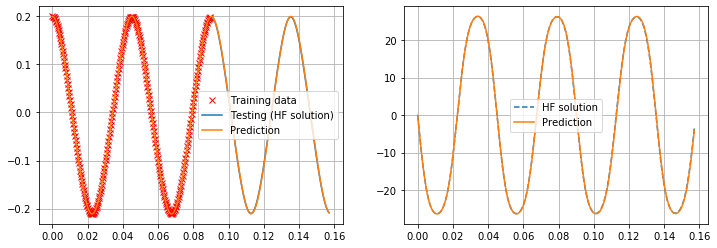

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_t, train_disp[0, :], 'rx', label = "Training data");
ax[0].plot(test_t, test_disp[0, :], label = "Testing (HF solution)");
ax[0].plot(sol.t, sol.y[0], label = "Prediction");
ax[0].grid();
ax[0].legend();

ax[1].plot(t, velocity, '--', label = "HF solution");
ax[1].plot(sol.t, sol.y[1], label = "Prediction");
ax[1].grid();
ax[1].legend();

In [10]:
print("Training time, t = ", drom.profile["Training time"])
print("Prediction time, t = ", t1-t0, " s")

Training time, t =  0.05859375
Prediction time, t =  0.048706769943237305  s
